# Importing necessary libraries

In [2]:
#importing the necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import math 
import sys
import statistics as stats

# Import .csv Files

In [3]:
#importing movie_budgets_clean.csv
movie_budgets_clean= pd.read_csv('databases/movie_budgets_clean.csv')

In [4]:
#checking for null values and datatypes
movie_budgets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5234 entries, 0 to 5233
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5234 non-null   int64 
 1   release_date       5234 non-null   object
 2   movie              5234 non-null   object
 3   production_budget  5234 non-null   int64 
 4   domestic_gross     5234 non-null   int64 
 5   worldwide_gross    5234 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 245.5+ KB


# Data Engineering and Manipulation

In [5]:
#adding column 'profit' for each movies total profit
movie_budgets_clean['profit'] = movie_budgets_clean['worldwide_gross'] - movie_budgets_clean['production_budget']


In [6]:
#calculate the return on investment(ROI) for each movie
movie_budgets_clean['roi'] = (movie_budgets_clean['worldwide_gross'] / movie_budgets_clean['production_budget'] ) -1

In [7]:
#checkpoint to inspect data with additional columns
movie_budgets_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,roi
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696


In [8]:
#Evaluating descriptive statistics, mean is much higher then median for profit
# and ROI so we will remove outliers
movie_budgets_clean.describe()

,id,production_budget,domestic_gross,worldwide_gross,profit,roi
count,5234.000000,5.234000e+03,5.234000e+03,5.234000e+03,5.234000e+03,5234.000000
mean,50.346580,3.403348e+07,4.625747e+07,1.007615e+08,6.672803e+07,4.267876
std,28.848667,4.296048e+07,7.029651e+07,1.811226e+08,1.518522e+08,30.997659
min,1.000000,1.100000e+03,3.880000e+02,4.010000e+02,-2.002376e+08,-0.999875
25%,25.000000,6.500000e+06,4.289718e+06,8.142571e+06,-1.396634e+06,-0.241161
50%,50.000000,2.000000e+07,2.198422e+07,3.543844e+07,1.357260e+07,0.961653
75%,75.000000,4.500000e+07,5.756598e+07,1.093357e+08,7.088258e+07,3.059457
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,2.351345e+09,1799.000000


In [9]:
#remove outliers, any data below 2 standard deviations from the median are removed
movie_budgets_outliers = movie_budgets_clean[movie_budgets_clean['roi'] < 0.961653 + (2*30.997659)] 

In [10]:
#removing outliers from worldwide_gross column using the same method
movie_budgets_outliers = movie_budgets_clean[movie_budgets_clean['worldwide_gross'] < 3.543844e+07+(2*1.811226e+08) ]

In [11]:
#removing any production budget below $10M as we assume that Microsoft will spend at least that
movie_budgets_outliers = movie_budgets_clean[movie_budgets_clean['production_budget'] > 100000000]

In [12]:
#in order to complete a seasonality analysis we need to group data by month in order
#to access monthly data we need to break up the release_date column
date_split = movie_budgets_outliers.release_date.str.split(" ",expand=True)
#new dataframe called "date_split"  contains the month, day, year from the release_date column
date_split.head()

,0,1,2
0,Dec,"18,",2009
1,May,"20,",2011
2,Jun,"7,",2019
3,May,"1,",2015
4,Dec,"15,",2017


In [13]:
#we need to combine the date_split dataframe with the movie_budge_outliers dataframe
#to group revenue, profits and roi by month
seasonlity_analysis = pd.concat([date_split, movie_budgets_outliers], axis=1)
#forumula above concatenates the two dataframes into a new dataframe called 'seasonality_analysis' 
seasonlity_analysis.head()

,0,1,2,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,roi
0,Dec,"18,",2009,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577
1,May,"20,",2011,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673
2,Jun,"7,",2019,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108
3,May,"1,",2015,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841
4,Dec,"15,",2017,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696


In [14]:
#renaming the date columns
seasonlity_analysis = seasonlity_analysis.rename(columns={ 0 : 'month', 1: 'day', 2: 'year'})

In [15]:
seasonlity_analysis = seasonlity_analysis.sort_values('month')
#function above sort's the dataframe by the month column,
#months are not in order we need to find a solution to order the months
seasonlity_analysis

,month,day,year,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,roi
201,Apr,"8,",2005,3,"Apr 8, 2005",Sahara,145000000,68671925,121671925,-23328075,-0.160883
22,Apr,"14,",2017,23,"Apr 14, 2017",The Fate of the Furious,250000000,225764765,1234846267,984846267,3.939385
66,Apr,"3,",2015,67,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1328722794,6.993278
96,Apr,"15,",2016,97,"Apr 15, 2016",The Jungle Book,175000000,364001123,962854547,787854547,4.502026
308,Apr,"22,",2016,10,"Apr 22, 2016",The Huntsman: Winterâs War,115000000,48003015,165149302,50149302,0.436081
...,...,...,...,...,...,...,...,...,...,...,...
344,Oct,"2,",2015,46,"Oct 2, 2015",The Martian,108000000,228433663,655271443,547271443,5.067328
361,Oct,"26,",2012,63,"Oct 26, 2012",Cloud Atlas,102000000,27108272,130673154,28673154,0.281109
352,Sep,"22,",2017,54,"Sep 22, 2017",Kingsman: The Golden Circle,104000000,100234838,408803696,304803696,2.930805
328,Sep,"30,",2016,30,"Sep 30, 2016",Miss Peregrineâs Home for Peculiar Children,110000000,87242834,295986876,185986876,1.690790


In [16]:
#code below creates a dictionary of months with their rank
monthdict = { 'Jan' : 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, "May": 5, "Jun": 6,
         'Jul' : 7, 'Aug' : 8, 'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12}
#then we replace the current named months by a numberical value corresponding to
#each months ranked order in the year (below)
seasonlity_analysis = seasonlity_analysis.replace({'month': monthdict})                         

In [17]:
#in the code below we sort the dataframe by the new month column
seasonlity_analysis = seasonlity_analysis.sort_values('month')

In [18]:
#checking the dataframe to make sure that the months are in order as expected
seasonlity_analysis.head(15)

,month,day,year,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,roi
279,1,"13,",2017,81,"Jan 13, 2017",Monster Trucks,125000000,33370166,61642798,-63357202,-0.506858
327,1,"14,",2011,29,"Jan 14, 2011",The Green Hornet,110000000,98780042,229155503,119155503,1.083232
209,1,"29,",2016,11,"Jan 29, 2016",Kung Fu Panda 3,140000000,143528619,517599142,377599142,2.697137
190,2,"12,",2010,91,"Feb 12, 2010",The Wolfman,150000000,62189884,142634358,-7365642,-0.049104
90,2,"6,",2015,91,"Feb 6, 2015",Jupiter Ascending,179000000,47482519,181982519,2982519,0.016662
287,2,"16,",2007,89,"Feb 16, 2007",Ghost Rider,120000000,115802596,229545589,109545589,0.912880
191,2,"17,",2017,92,"Feb 17, 2017",The Great Wall,150000000,45157105,334486852,184486852,1.229912
123,2,"14,",2019,24,"Feb 14, 2019",Alita: Battle Angel,170000000,85710210,402976036,232976036,1.370447
294,2,"12,",2014,96,"Feb 12, 2014",RoboCop,120000000,58607007,242981799,122981799,1.024848
41,2,"16,",2018,42,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,1148258224,5.741291


In [24]:
annual_revenue = seasonlity_analysis.groupby('year').sum()
annual_revenue = annual_revenue.reset_index()
annual_revenue

,year,month,id,production_budget,domestic_gross,worldwide_gross,profit,roi
0,1995,7,10,175000000,88246220,264246220,89246220,0.509978
1,1997,38,191,660000000,1007254353,3114698485,2454698485,13.951443
2,1998,19,94,405000000,468337079,1216000000,811000000,6.008000
3,1999,48,270,800000000,1059086960,2418710614,1618710614,13.304906
4,2000,44,446,806800000,1198478366,2485216229,1678416229,14.571427
5,2001,62,288,851500000,1218407744,3054436730,2202936730,18.297222
6,2002,47,206,873000000,1303639645,2954564911,2081564911,16.395535
7,2003,88,479,1506000000,1769131489,4189853535,2683853535,18.962355
8,2004,96,604,1765000000,1789678676,4587000556,2822000556,20.218176
9,2005,111,629,1997000000,2442625456,6038108110,4041108110,28.866799


# Visualizing the data

Text(0.5, 1.0, 'Global Revenue Distribution by Month (in Billions USD)')

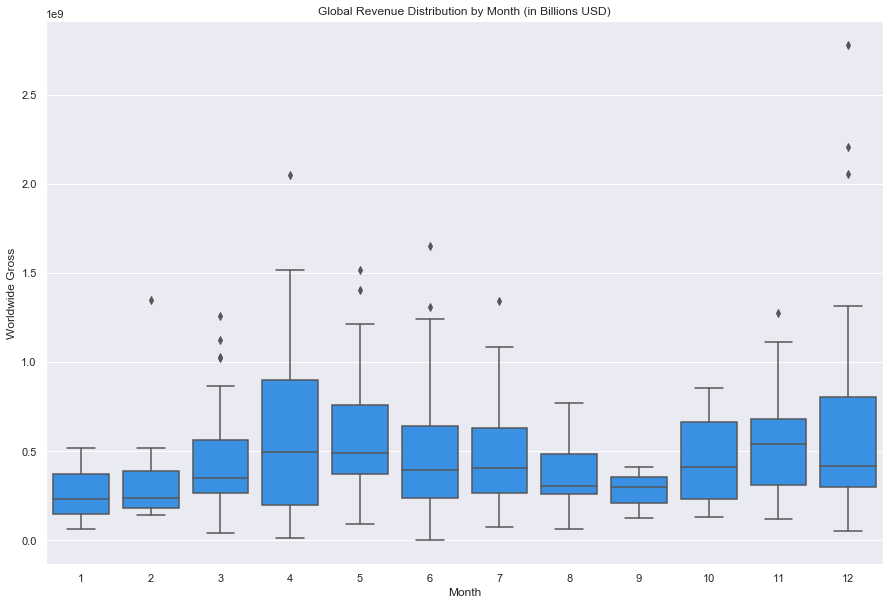

In [60]:
#creating a boxplot with Seaborn comparing each month on the worldwide_gross column
sns.set(rc={'figure.figsize':(15,10)})
palette = sns.color_palette('Blues')
axis = sns.boxplot(x= seasonlity_analysis['month'], 
                   y= seasonlity_analysis['worldwide_gross'], 
                   data=seasonlity_analysis, color= 'dodgerblue')
axis = axis.set(xlabel='Month', ylabel='Worldwide Gross')
plt.title('Global Revenue Distribution by Month (in Billions USD)')


Text(0.5, 1.0, 'Return on Investment Distribution by Month (in percentages)')

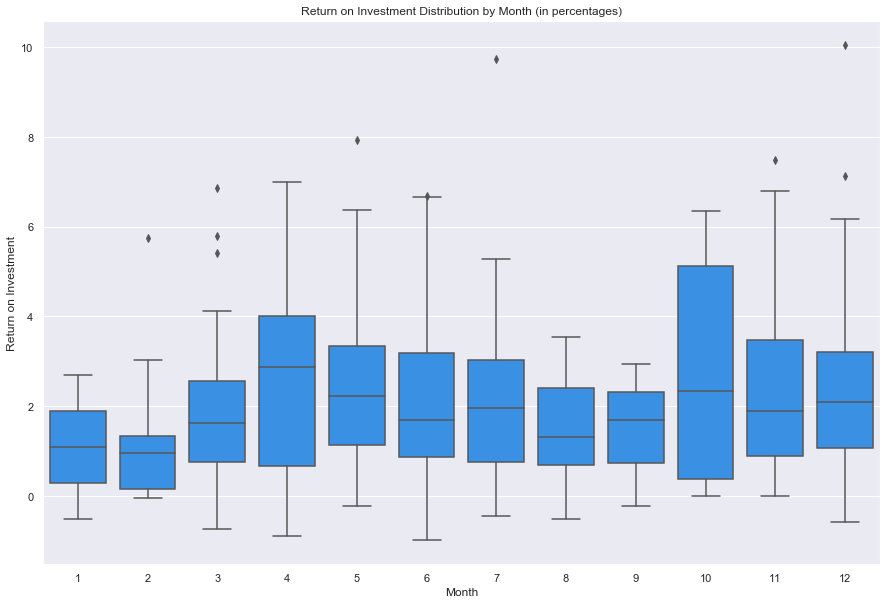

In [61]:
#creating a boxplot with Seaborn comparing each month on the roi column

axis2 = sns.boxplot(x= seasonlity_analysis['month'], y= seasonlity_analysis['roi'], data=seasonlity_analysis, color= 'dodgerblue')
axis2 = axis2.set(xlabel='Month', ylabel='Return on Investment',)
plt.title('Return on Investment Distribution by Month (in percentages)')

Text(0.5, 1.0, 'Profit Distribution by Month (in Billions USD')

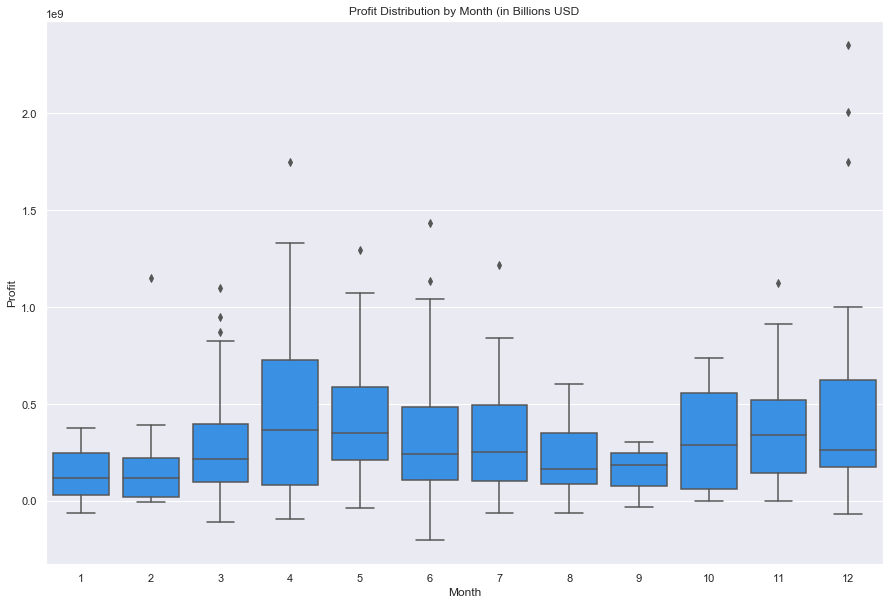

In [62]:
#creating a boxplot with Seaborn comparing each month on the roi column
axis3 =sns.boxplot(x= seasonlity_analysis['month'], y= seasonlity_analysis['profit'], data=seasonlity_analysis, color= 'dodgerblue')
axis3 = axis3.set(xlabel='Month', ylabel='Profit',)
plt.title('Profit Distribution by Month (in Billions USD')

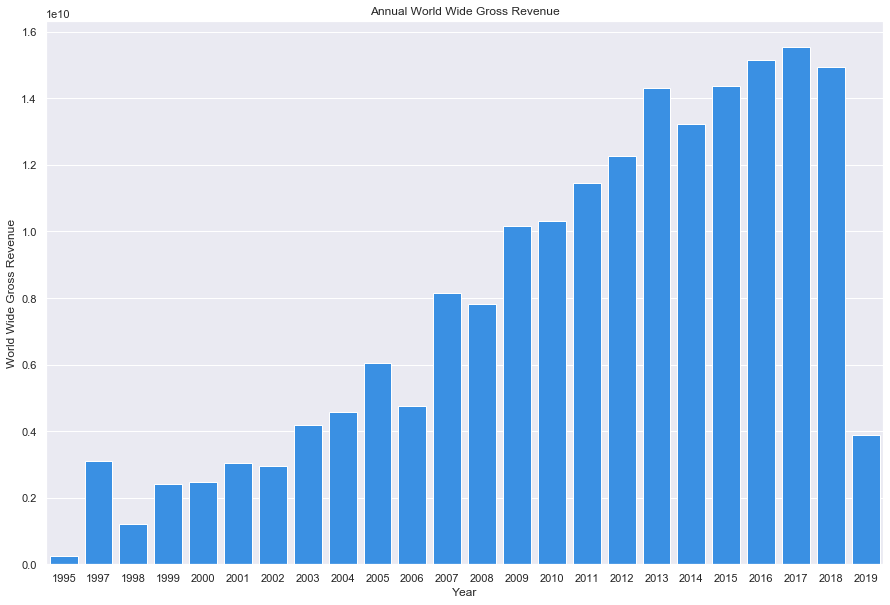

In [63]:
axis4= sns.barplot(x='year', y='worldwide_gross', data=annual_revenue, color= 'dodgerblue');
axis4= axis4.set(xlabel='Year', ylabel='World Wide Gross Revenue');
plt.title('Annual World Wide Gross Revenue')
plt.show()